Avant de lancer ce NB, je lance le terminal Anaconda et je copie colle : 
mlflow server --host 127.0.0.1 --port 8080 

Ca lance MLFlow

Pour ce projet, nous avons suivi le schéma présenté dans cet article:
https://towardsdatascience.com/a-complete-machine-learning-walk-through-in-python-part-one-c62152f39420

## 1.1 - Imports


In [1]:
import mlflow
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score, f1_score, fbeta_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import lightgbm as lgb

from mlflow.models import infer_signature
from lightgbm import early_stopping

import shap
# Memory management
import gc 

In [2]:
# démarrage du tracking
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

In [3]:
train_small=pd.read_csv('train_small.csv')

In [4]:
train_small.head()

,EXT_SOURCE_1,CREDIT_TERM,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED,DAYS_BIRTH,client_installments_AMT_PAYMENT_min_sum,AMT_ANNUITY,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,client_cash_CNT_INSTALMENT_FUTURE_mean_max,OWN_CAR_AGE,bureau_AMT_CREDIT_SUM_DEBT_mean,AMT_CREDIT,DAYS_ID_PUBLISH,TARGET,SK_ID_CURR
0,0.083037,0.060749,0.262949,0.139376,-637.0,9461,175783.73,24700.5,-103.0,780.0,15.000,NaN,49156.2,406597.5,-2120,True,100002
1,0.311267,0.027598,0.622246,NaN,-1188.0,16765,1154108.20,35698.5,-606.0,1216.0,7.875,NaN,0.0,1293502.5,-291,False,100003
2,NaN,0.050000,0.555912,0.729567,-225.0,19046,16071.75,6750.0,-408.0,-382.0,2.250,26.0,0.0,135000.0,-2531,False,100004
3,NaN,0.094941,0.650442,NaN,-3039.0,19005,994476.70,29686.5,NaN,NaN,16.000,NaN,NaN,312682.5,-2437,False,100006
4,NaN,0.042623,0.322738,NaN,-3038.0,19932,483756.38,21865.5,-1149.0,-783.0,18.500,NaN,0.0,513000.0,-3458,False,100007


In [5]:
train_small.shape

(307511, 17)

In [6]:
train_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   EXT_SOURCE_1                                134133 non-null  float64
 1   CREDIT_TERM                                 307499 non-null  float64
 2   EXT_SOURCE_2                                306851 non-null  float64
 3   EXT_SOURCE_3                                246546 non-null  float64
 4   DAYS_EMPLOYED                               252137 non-null  float64
 5   DAYS_BIRTH                                  307511 non-null  int64  
 6   client_installments_AMT_PAYMENT_min_sum     291643 non-null  float64
 7   AMT_ANNUITY                                 307499 non-null  float64
 8   bureau_DAYS_CREDIT_max                      263491 non-null  float64
 9   bureau_DAYS_CREDIT_ENDDATE_max              261242 non-null  float64
 

In [7]:
train_small=train_small.drop(['AMT_CREDIT', 'AMT_ANNUITY', 'CREDIT_TERM'], axis=1)

In [8]:
train_small.shape

(307511, 14)

# 5 - Nouvelle modélisation LGBM avec short selection de features

In [9]:
train_s, test_s = train_test_split(train_small, test_size=0.2, random_state=42)

# Extraire les identifiants, les cibles et les caractéristiques pour les ensembles d'entraînement et de test
X_train_s = train_s.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y_train_s = train_s['TARGET']
id_train_s = train_s['SK_ID_CURR']

X_test_s = test_s.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y_test_s = test_s['TARGET']
id_test_s = test_s['SK_ID_CURR']
    


In [10]:
# X_train_s, X_test_s, y_train_s, y_test_s, id_train_s, id_test_s=prepare_modelisation (train_small)

In [11]:
X_train_s.shape, X_test_s.shape, y_train_s.shape, y_test_s.shape, id_train_s.shape, id_test_s.shape

((246008, 12), (61503, 12), (246008,), (61503,), (246008,), (61503,))

# **FONCTION DU NB 1 A SUPPRIMER QUAND ON GROUPERA LES NB**

In [12]:
def custom_f1(y_true, y_pred_proba):
    thresholds = np.linspace(0, 1, 100)
    best_threshold = 0.5
    best_f1 = 0
    best_cost = float('inf')
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        # Calculer les coûts
        fn = np.sum((y_true == 1) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        cost = fn * 10 + fp
        
        # Sélectionner le seuil basé sur le coût le plus bas
        if cost < best_cost:
            best_f1 = f1
            best_threshold = threshold
            best_cost = cost
    
    return best_f1

In [13]:


def custom_recall(y_true, y_pred_proba):
    thresholds = np.linspace(0, 1, 100)
    best_threshold = 0.5
    best_recall = 0
    best_cost = float('inf')
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        recall = recall_score(y_true, y_pred)
        # Calculer les coûts
        fn = np.sum((y_true == 1) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        cost = fn * 10 + fp
        
        # Sélectionner le seuil basé sur le coût le plus bas
        if cost < best_cost:
            best_recall = recall
            best_threshold = threshold
            best_cost = cost
    
    return best_recall

In [14]:
# Fonction pour détecter les colonnes avec 2 valeurs uniques ou moins
def detect_columns(X):
    
    categorical_columns = [col for col in X.columns if X[col].dtype in ['object', 'bool']]
    numerical_columns = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
    return categorical_columns, numerical_columns

def run_grid_search(X_train, y_train, model, param_grid, fit_params=None, train_size=1.0):
    # Détecter les types de colonnes
    categorical_columns, numerical_columns = detect_columns(X_train)

    # Définir les préprocesseurs pour chaque type de colonne
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler(feature_range=(0, 1)))
            ]), numerical_columns),
            
                     
            ('cat', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ]), categorical_columns)
        ],
        remainder='passthrough'
    )

    # Pipeline complète
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('sampling', SMOTE(random_state=42)),
        ('model', model)
    ])

    # Mettre à jour le param_grid pour correspondre au pipeline
    param_grid = {f'model__{key}': value for key, value in param_grid.items()}

    # Définir les scorers personnalisés
    scorers = {
        'AUC': 'roc_auc',
        'F1_opt': make_scorer(custom_f1, needs_proba=True),
        'recall_opt': make_scorer(custom_recall, needs_proba=True)
    }

    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring=scorers,
        refit='AUC',
        cv=2,
        verbose=3,
        return_train_score=True
    )

    # Fractionnement des données si train_size < 1.0
    if train_size < 1.0:
        X_train_sample, X_val_sample, y_train_sample, y_val_sample = train_test_split(X_train, y_train, train_size=train_size, random_state=42)
        data_to_fit = (X_train_sample, y_train_sample)
        eval_set = [(X_val_sample, y_val_sample)]
    else:
        data_to_fit = (X_train, y_train)
        eval_set = [(X_train, y_train)]

    # Mettre à jour les fit_params avec eval_set
    if fit_params is None:
        fit_params = {}
    fit_params['eval_set'] = eval_set

    # Entraînement
    start_time = time.time()
    grid_search.fit(*data_to_fit, **{f'model__{key}': value for key, value in fit_params.items()})
    end_time = time.time()

    execution_time = round(end_time - start_time, 2)
    print(f"Le temps d'execution est de {execution_time} secondes.")

    return {
        'best_model' : grid_search.best_estimator_,
        'best_params_': grid_search.best_params_,
        'best_score_': grid_search.best_score_,
        'cv_results_': grid_search.cv_results_
    }

In [15]:
def extract_best_auc_result(results):
    """
    Extracts the best model configuration based on AUC score from the cv_results of a GridSearchCV.
    
    Parameters:
    - results (dict): A dictionary output from the run_grid_search function containing 'cv_results_'.
    
    Returns:
    - DataFrame: A DataFrame containing the best scoring row based on the AUC rank.
    """
    # Conversion of cv_results_ into a DataFrame
    cv_results = results['cv_results_']
    df_cv_results = pd.DataFrame(cv_results)
    
    # Sorting the DataFrame by the rank of the AUC test scores
    df_cv_results = df_cv_results.sort_values(by="rank_test_AUC", ascending=True)
    
    # Returning the top entry
    return df_cv_results.head(1)

In [16]:
def plot_auc_scores(best_auc_result):
    """
    Plots the AUC scores from cross-validation folds for the best model configuration based on rank.
    
    Parameters:
    - best_auc_result (DataFrame): A DataFrame with the top row from cv_results_ sorted by AUC.
    - full_cv_results (DataFrame): The full cv_results DataFrame to extract mean scores for rank 1.
    """
    # Extract the AUC scores for each fold for the best AUC configuration
    df_train_results_auc = best_auc_result[[
        'split0_train_AUC', 
        'split1_train_AUC', 
        # 'split2_test_AUC', 
        # 'split3_test_AUC', 
        # 'split4_test_AUC'
    ]][best_auc_result['rank_test_AUC'] == 1].values
    
    df_test_results_auc = best_auc_result[[
        'split0_test_AUC', 
        'split1_test_AUC', 
        # 'split2_test_AUC', 
        # 'split3_test_AUC', 
        # 'split4_test_AUC'
    ]][best_auc_result['rank_test_AUC'] == 1].values
    
    fig, ax = plt.subplots(figsize=(8, 4))
    
    # Plot the train scores
    ax.plot(range(0, 2), df_test_results_auc.reshape(-1), label='Scores de validation')
    
    # Plot the test scores
    ax.plot(range(0, 2), df_train_results_auc.reshape(-1), label='Scores de train')

    # # Plot the average for the combinations with rank_test_AUC == 1
    # mean_scores_rank_1 = best_auc_result.loc[best_auc_result['rank_test_AUC'] == 1, 'mean_test_AUC']
    # ax.axhline(y=mean_scores_rank_1.values[0], color='g', linestyle='--', label='Moyenne (rank 1)')
    
    # Set the properties of the axis
    ax.set_xticks(range(0, 2))
    ax.set_xlabel("Folds de cross-validation")
    ax.set_ylabel('AUC')
    ax.set_title("AUC de chaque fold \n pour la combinaison d'hyperparamètres \n qui arrive au rang 1 en terme d'AUC", fontsize=15, weight="bold", fontname="Impact", color="#0e2452")
    
    # Add a legend
    ax.legend()

    fig.tight_layout()
    
    plt.show()


In [17]:
# fonction qui va établir un seuil pour convertir les probabiliiéts en étiquettes de classe binaire. 
# à partir de la matrice de confusion, on va calculer le coût

def calculate_cost_threshold(y_true, probas, threshold, cost_fn, cost_fp):
    y_pred = (probas >= threshold).astype(int) # transforme les probas en prédictions binaires en utilisant un seuil. 
                                                # Les probabilités >= au seuil sont marquées comme 1 (positives),
                                                # les autres comme 0 (négatives).

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel() # .ravel() convertit la matrice 2x2 en un tableau à une dimension [tn, fp, fn, tp]
                                                            # permet une extraction facile de chaque valeur
    return cost_fn * fn + cost_fp * fp

In [18]:
def evaluate_model (X_train, y_train, X_test, y_test, best_model):

    start_predict_time = time.time()
    # Predict on the training data
    y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]
    
    # Predict on the test data
    y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

    end_predict_time = time.time()

    # Calculate AUC for training and test data
    auc_train = round(roc_auc_score(y_train, y_train_pred_proba),2)
    auc_test = round(roc_auc_score(y_test, y_test_pred_proba),2)

    # Find the optimal threshold for cost function on the training data
    thresholds = np.linspace(0, 1, 100)
    costs = [calculate_cost_threshold(y_test, y_test_pred_proba, thr, cost_fn=10, cost_fp=1) for thr in thresholds]
    optimal_threshold = round(thresholds[np.argmin(costs)],2) 

    # Metrics at the optimal threshold
    y_test_pred_opt = (y_test_pred_proba >= optimal_threshold).astype(int)
    
    f1_score_1_test = f1_score(y_test, y_test_pred_opt)
    recall_1_test = recall_score(y_test, y_test_pred_opt)
    accuracy_test = accuracy_score(y_test, y_test_pred_opt)
    
    return {
        'predicting_execution_time': round(end_predict_time - start_predict_time, 2),
        'auc_train': auc_train,
        'auc_test': auc_test,
        'optimal_threshold': optimal_threshold,
        'f1_score_1_test': round(f1_score_1_test,2),
        'recall_1_test': round(recall_1_test,2),
        'accuracy_test': round(accuracy_test,2)
    }

In [19]:
def show_feature_importances(importances, features):
    # Création du DataFrame

    importances = importances.flatten()
    
    feature_importances = pd.DataFrame({
        'feature': features, 
        'importance': importances
    })
    
    # Tri et sélection des 10 caractéristiques les plus importantes
    feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False).reset_index(drop=True)
    feature_importances_sorted = feature_importances_sorted.head(10)
    
    # Normalisation des importances
    feature_importances_sorted['importance_normalized'] = feature_importances_sorted['importance'] / feature_importances_sorted['importance'].sum()
    
    # Création du graphique à barres horizontales
    plt.figure(figsize=(10, 6))
    ax = plt.subplot()
    
    # Inversion de l'index pour afficher la plus importante en haut
    indices = list(reversed(list(feature_importances_sorted.index)))
    ax.barh(indices, feature_importances_sorted['importance_normalized'], align='center', edgecolor='k')
    
    # Définition des étiquettes y
    ax.set_yticks(indices)
    ax.set_yticklabels(feature_importances_sorted['feature'])
    
    # Étiquetage du graphique
    plt.xlabel('Normalized Importance')
    plt.title('Top 10 Feature Importances')
    plt.show()
    
    return feature_importances_sorted



# **FIN DES FONCTIONS DU NB 1 A SUPPRIMER QUAND ON GROUPERA LES NB**

In [20]:
model_LGBM_3 = lgb.LGBMClassifier(objective='binary',
                                boosting_type = 'goss',
                                # class_weight = 'balanced',
                                random_state = 50)
        
param_grid_LGBM_3 = {
    # 'num_leaves': [35,40],
    'n_estimators' : [20,30,50,100],   
    'learning_rate' : [0.01,0.05,0.07, 0.1],
}

# Paramètres pour early_stopping
fit_params = {
    'eval_metric': 'auc',
    'callbacks': [lgb.early_stopping(stopping_rounds=50)]
}


In [21]:
# Execution de la fonction
start_training_time = time.time()

results_LGBM_3 = run_grid_search(X_train_s, y_train_s, model_LGBM_3, param_grid_LGBM_3,fit_params)

end_training_time = time.time()

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 113066, number of negative: 113066
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3056
[LightGBM] [Info] Number of data points in the train set: 226132, number of used features: 12
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt,

In [22]:
training_execution_time = round(end_training_time - start_training_time,2)  
print(f"Le temps d'exécution est de {training_execution_time} secondes.")

Le temps d'exécution est de 264.52 secondes.


In [23]:
best_model_lgbm_3 = results_LGBM_3['best_model']
best_params_lgbm_3 = results_LGBM_3['best_params_']
best_score_lgbm_3 = results_LGBM_3['best_score_']
cv_results_lgbm_3 = results_LGBM_3['cv_results_']

print("Best Params:", best_params_lgbm_3)
print("Best AUC:", best_score_lgbm_3)

Best Params: {'model__learning_rate': 0.05, 'model__n_estimators': 30}
Best AUC: 0.6980282087114271


In [24]:
best_auc_result_LGBM_3 = extract_best_auc_result(results_LGBM_3)
best_auc_result_LGBM_3.head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__n_estimators,params,split0_test_AUC,split1_test_AUC,mean_test_AUC,...,std_train_F1_opt,split0_test_recall_opt,split1_test_recall_opt,mean_test_recall_opt,std_test_recall_opt,rank_test_recall_opt,split0_train_recall_opt,split1_train_recall_opt,mean_train_recall_opt,std_train_recall_opt
5,1.109947,0.043904,3.594733,0.178621,0.05,30,"{'model__learning_rate': 0.05, 'model__n_estim...",0.708063,0.687993,0.698028,...,0.000786,0.602435,0.48873,0.545583,0.056852,10,0.590058,0.503019,0.546539,0.04352


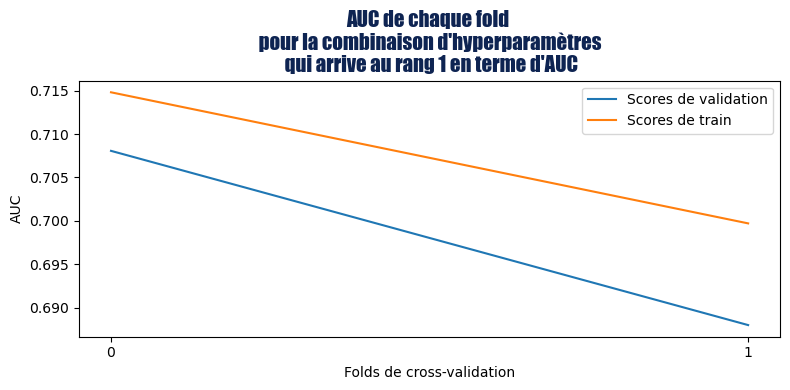

In [25]:
plot_auc_scores(best_auc_result_LGBM_3)

In [26]:
result_lgbm_3=evaluate_model (X_train_s, y_train_s, X_test_s, y_test_s, best_model_lgbm_3)
result_lgbm_3


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


{'predicting_execution_time': 0.11,
 'auc_train': 0.7,
 'auc_test': 0.69,
 'optimal_threshold': 0.51,
 'f1_score_1_test': 0.25,
 'recall_1_test': 0.5,
 'accuracy_test': 0.75}

# 7 - Enregistrement du modèle dans MLFlow

In [27]:
# Création d'une nouvelle expérience MLflow
mlflow.set_experiment("MLflow Credit_Scoring - Projet_7")

# Commencer une session MLflow
with mlflow.start_run():
    # Log les hyperparameters que j'ai déclarés au dessus
    mlflow.log_params(best_params_lgbm_3)

    # Log les métriques
    
    mlflow.log_metric("optimal_threshold", result_lgbm_3['optimal_threshold'])

    mlflow.log_metric("recall_1_test", result_lgbm_3['recall_1_test'])
    mlflow.log_metric("f1_score_1_test", result_lgbm_3['f1_score_1_test'])
    mlflow.log_metric("accuracy du test", result_lgbm_3['accuracy_test'])
    
    mlflow.log_metric("auc_train", result_lgbm_3['auc_train'])
    mlflow.log_metric("auc_test", result_lgbm_3['auc_test'])
    
    mlflow.log_metric("temps_fit", training_execution_time)
    mlflow.log_metric("temps_predict", result_lgbm_3['predicting_execution_time'])

    
 
    

    # Définir un tag pour se rappeler l'objet de cette session
    mlflow.set_tag("Training Info", "LGBM with 15 features")

    # Infer the model signature
    signature = infer_signature(X_train_s, best_model_lgbm_3.predict(X_train_s)) # infer_signature génère automatiquement une "signature" 
                                                              # qui décrit les entrées et les sorties du modèle. 
                                                              # Cela inclut les types de données et les formats attendus par le modèle, 
                                                              # facilitant ainsi l'intégration et la réutilisation du modèle 
                                                              # dans différents environnements.

    
       # Log le modèle
    model_info = mlflow.lightgbm.log_model(
        lgb_model=best_model_lgbm_3.named_steps['model'],
        artifact_path="lgbm_classifier_model",
        signature=signature,
        input_example=X_train_s,
        registered_model_name="scoring-credit-lgbm_classifier",
    )

    # Afficher l'URI du modèle
    model_uri = model_info.model_uri
    print(f"Model URI: {model_uri}")

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


Registered model 'scoring-credit-lgbm_classifier' already exists. Creating a new version of this model...
2024/06/30 16:14:41 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: scoring-credit-lgbm_classifier, version 17


Model URI: runs:/43be00c851724756aa0f6408ec39c83d/lgbm_classifier_model


Created version '17' of model 'scoring-credit-lgbm_classifier'.


# 8 - Interprétation des résultats

## 8.1 - Feature Importance

In [28]:
importances = best_model_lgbm_3.named_steps['model'].feature_importances_
features= X_train_s.columns

In [29]:
importances

array([12, 20, 12, 24,  0, 14,  8,  0,  4,  7, 19,  0])

In [30]:
X_train_s.head(1)

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED,DAYS_BIRTH,client_installments_AMT_PAYMENT_min_sum,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,client_cash_CNT_INSTALMENT_FUTURE_mean_max,OWN_CAR_AGE,bureau_AMT_CREDIT_SUM_DEBT_mean,DAYS_ID_PUBLISH
123473,0.524685,0.358569,0.563835,NaN,23349,670327.3,-599.0,759.0,25.59091,31.0,64721.812,-4408


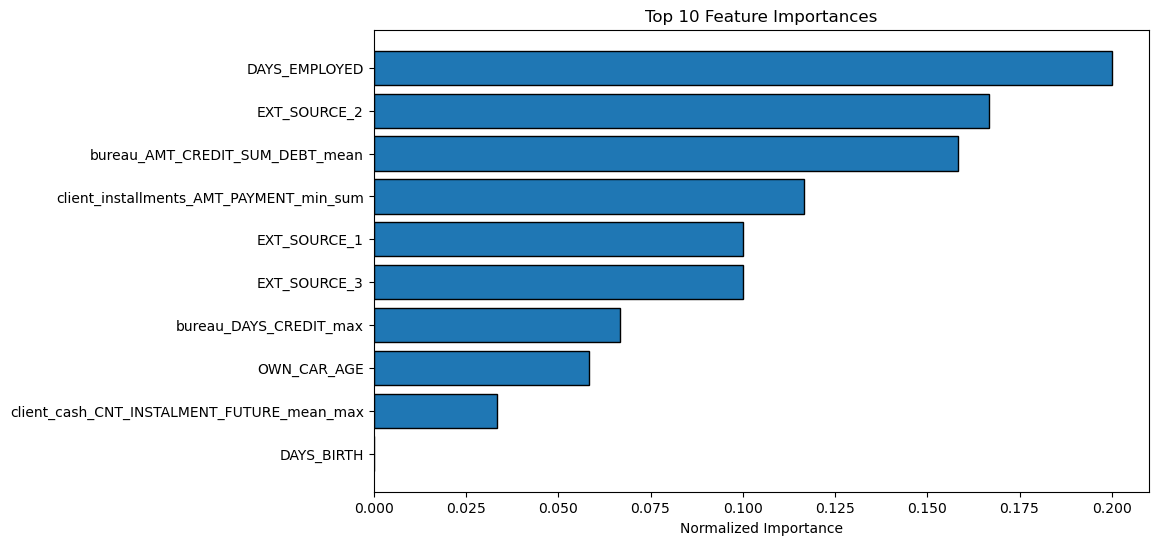

,feature,importance,importance_normalized
0,DAYS_EMPLOYED,24,0.200000
1,EXT_SOURCE_2,20,0.166667
2,bureau_AMT_CREDIT_SUM_DEBT_mean,19,0.158333
3,client_installments_AMT_PAYMENT_min_sum,14,0.116667
4,EXT_SOURCE_1,12,0.100000
5,EXT_SOURCE_3,12,0.100000
6,bureau_DAYS_CREDIT_max,8,0.066667
7,OWN_CAR_AGE,7,0.058333
8,client_cash_CNT_INSTALMENT_FUTURE_mean_max,4,0.033333
9,DAYS_BIRTH,0,0.000000


In [31]:
show_feature_importances(importances, features)

## 8.2 - Shap Values

### 8.2.1 - Interprétation globale du test

In [32]:
# on s'assure que le meilleur modèle est extrait de la pipeline
best_model=best_model_lgbm_3.named_steps['model']

In [33]:
# # Comme le SMOTE est appliqué dans le pipeline, nous devons transformer les données X_test_r avant d'appliquer SHAP
# # Pour cela, nous utilisons le transformateur dans le pipeline avant le modèle
# data_for_shap = results_LGBM_2['best_model'].named_steps['sampling'].fit_resample(X_test_r, y_test_r)

In [34]:
# # Extraction des données transformées qui sont maintenant suréchantillonnées
# X_test_resampled, y_test_resampled = data_for_shap

In [35]:
# Initialisation de l'Explainer SHAP avec le meilleur modèle obtenu sur le jeu de données de test original
explainer = shap.Explainer(best_model)

In [36]:
# Calcul des valeurs SHAP sur les données de test
shap_values = explainer.shap_values(X_test_s)

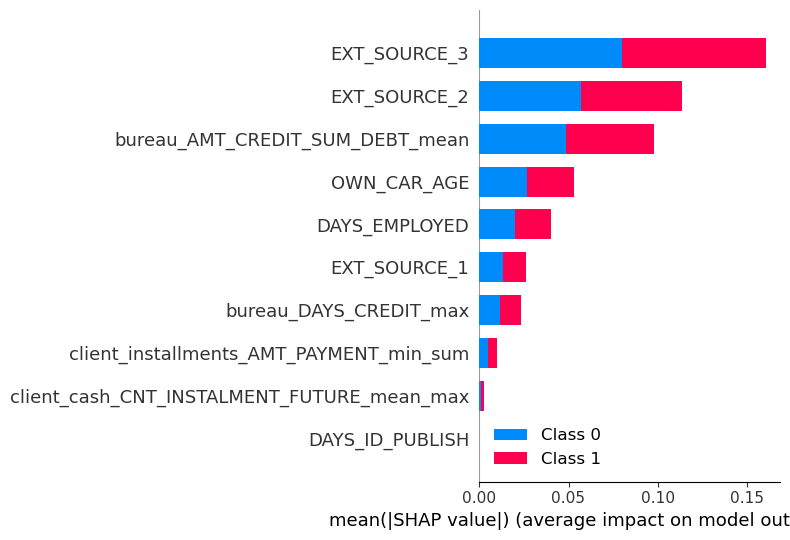

In [37]:
# Créer un graphique récapitulatif SHAP pour l'ensemble des données transformées
shap.summary_plot(shap_values, X_test_s, 
                  plot_type="bar",
                 max_display=10)

Si on regarde ce qui se passe pour la classe 1 :

In [38]:
shap_values_class1 = shap_values[1]

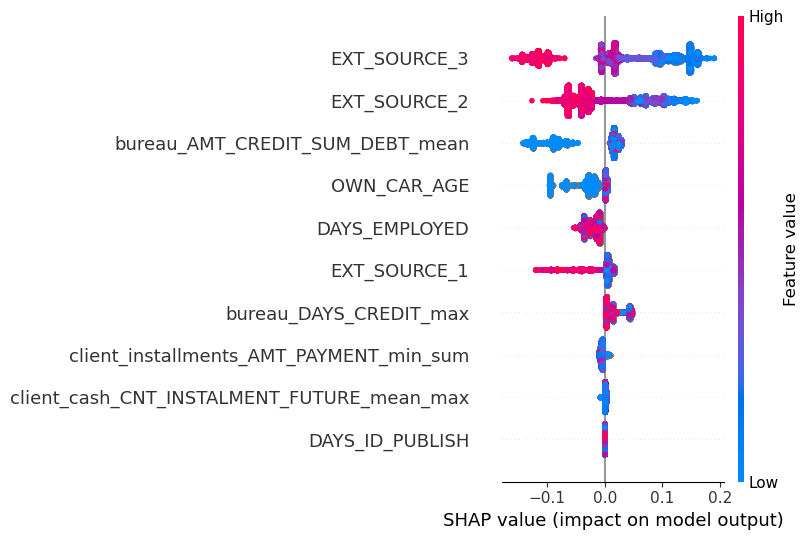

In [39]:
# Graphique récapitulatif SHAP pour la classe 1
shap.summary_plot(shap_values_class1, 
                  X_test_s, 
                  max_display=10)

### 8.2.2 - Interprétation locale

#### 8.2.2.1 - Reconstruction du test

In [40]:
# id_test_s.head()

In [41]:
# X_test_s.head()

In [42]:
# y_test_s.head()

In [43]:
# verif
train_small[train_small['SK_ID_CURR']==100002]

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED,DAYS_BIRTH,client_installments_AMT_PAYMENT_min_sum,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,client_cash_CNT_INSTALMENT_FUTURE_mean_max,OWN_CAR_AGE,bureau_AMT_CREDIT_SUM_DEBT_mean,DAYS_ID_PUBLISH,TARGET,SK_ID_CURR
0,0.083037,0.262949,0.139376,-637.0,9461,175783.73,-103.0,780.0,15.0,NaN,49156.2,-2120,True,100002


In [44]:
# # reconstruction du test
# test_dataset = pd.concat([X_test_s, y_test_s.reset_index(drop=True), id_test_s.reset_index(drop=True)], axis=1)
# verif
test_s[test_s['SK_ID_CURR']==100002]

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED,DAYS_BIRTH,client_installments_AMT_PAYMENT_min_sum,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,client_cash_CNT_INSTALMENT_FUTURE_mean_max,OWN_CAR_AGE,bureau_AMT_CREDIT_SUM_DEBT_mean,DAYS_ID_PUBLISH,TARGET,SK_ID_CURR
0,0.083037,0.262949,0.139376,-637.0,9461,175783.73,-103.0,780.0,15.0,NaN,49156.2,-2120,True,100002


In [45]:
# predict proba avec le best model
y_test_pred_proba = best_model_lgbm_3.predict_proba(X_test_s)[:, 1]

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


In [46]:
# Find the optimal threshold for cost function on the training data
thresholds = np.linspace(0, 1, 100)
costs = [calculate_cost_threshold(y_test_s, y_test_pred_proba, thr, cost_fn=10, cost_fp=1) for thr in thresholds]
optimal_threshold = round(thresholds[np.argmin(costs)],2) 

# Metrics at the optimal threshold
y_test_pred_opt = (y_test_pred_proba >= optimal_threshold).astype(int)

In [47]:
test_s['target_pred']=y_test_pred_opt
test_s['proba']=y_test_pred_proba

test_s[test_s['SK_ID_CURR']==100002]

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED,DAYS_BIRTH,client_installments_AMT_PAYMENT_min_sum,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,client_cash_CNT_INSTALMENT_FUTURE_mean_max,OWN_CAR_AGE,bureau_AMT_CREDIT_SUM_DEBT_mean,DAYS_ID_PUBLISH,TARGET,SK_ID_CURR,target_pred,proba
0,0.083037,0.262949,0.139376,-637.0,9461,175783.73,-103.0,780.0,15.0,NaN,49156.2,-2120,True,100002,1,0.542557


In [48]:
pd.crosstab(y_test_s, y_test_pred_opt, rownames=['Classes réelles'], colnames=['Classes prédites'])

Classes prédites,0,1
Classes réelles,,
False,43887,12667
True,2460,2489


In [49]:
print(classification_report(y_test_s, y_test_pred_opt))

              precision    recall  f1-score   support

       False       0.95      0.78      0.85     56554
        True       0.16      0.50      0.25      4949

    accuracy                           0.75     61503
   macro avg       0.56      0.64      0.55     61503
weighted avg       0.88      0.75      0.80     61503



#### 8.2.2.2 - Interprétation d'un individu prédit en classe 1

In [50]:
test_s[test_s['target_pred']==1].head()

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED,DAYS_BIRTH,client_installments_AMT_PAYMENT_min_sum,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,client_cash_CNT_INSTALMENT_FUTURE_mean_max,OWN_CAR_AGE,bureau_AMT_CREDIT_SUM_DEBT_mean,DAYS_ID_PUBLISH,TARGET,SK_ID_CURR,target_pred,proba
36463,0.527239,0.531760,0.207964,-639.0,17907,77640.880,-399.0,1189.0,5.0,4.0,238527.750,-1461,False,142232,1,0.516799
226343,NaN,0.519127,0.104795,NaN,19130,374056.030,-154.0,211.0,17.5,NaN,34645.500,-959,False,362171,1,0.512261
76671,NaN,0.574664,0.180888,NaN,22532,43717.094,-51.0,894.0,30.5,NaN,48280.965,-4226,False,188909,1,0.540709
130021,0.369833,0.512841,0.221335,-831.0,11214,NaN,-382.0,1444.0,NaN,15.0,159666.000,-626,False,250804,1,0.540709
16847,NaN,0.142871,NaN,-931.0,12178,115225.110,NaN,NaN,12.0,NaN,NaN,-4449,False,119647,1,0.560061


In [51]:
test_s[test_s['SK_ID_CURR']==142232]

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED,DAYS_BIRTH,client_installments_AMT_PAYMENT_min_sum,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,client_cash_CNT_INSTALMENT_FUTURE_mean_max,OWN_CAR_AGE,bureau_AMT_CREDIT_SUM_DEBT_mean,DAYS_ID_PUBLISH,TARGET,SK_ID_CURR,target_pred,proba
36463,0.527239,0.53176,0.207964,-639.0,17907,77640.88,-399.0,1189.0,5.0,4.0,238527.75,-1461,False,142232,1,0.516799


In [52]:
specific_id = 142232
index=test_s[test_s['SK_ID_CURR']==specific_id].index[0]

In [53]:
individual_shap_values = shap_values[1][index]  # Choix de la classe positive 

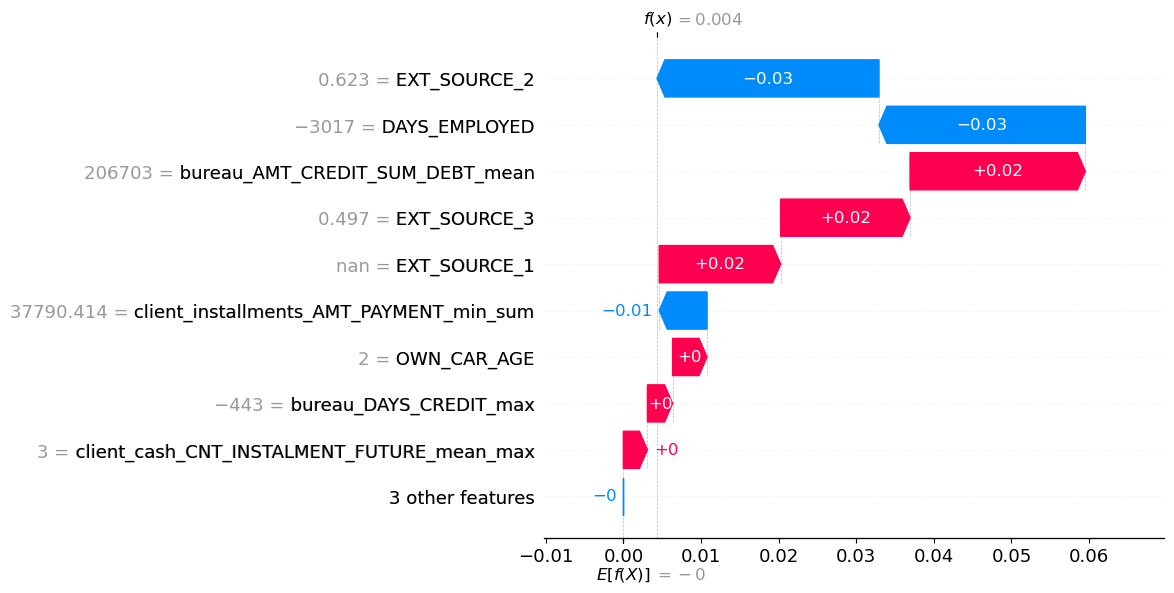

In [54]:
# Créer le graphique waterfall pour cet individu
shap.plots.waterfall(shap.Explanation(values=individual_shap_values,
                                      base_values=explainer.expected_value[1], # Assurez-vous de choisir la bonne valeur de base
                                      data=X_test_s.iloc[index],         # Données de l'individu à l'index 0
                                      feature_names=X_test_s.columns.tolist())) # Noms des caractéristiques



#### 8.2.2.3 - Interprétation d'un individu prédit en classe 0

In [67]:
test_s[test_s['target_pred']==0].head()

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED,DAYS_BIRTH,client_installments_AMT_PAYMENT_min_sum,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,client_cash_CNT_INSTALMENT_FUTURE_mean_max,OWN_CAR_AGE,bureau_AMT_CREDIT_SUM_DEBT_mean,DAYS_ID_PUBLISH,TARGET,SK_ID_CURR,target_pred,proba
245895,0.675878,0.604894,0.000527,-762.0,13297,30195.406,-129.0,231.0,6.000000,19.0,39569.785,-4307,False,384575,0,0.487253
98194,0.430827,0.425351,0.712155,-1141.0,14778,1345559.400,-295.0,9479.0,7.666666,11.0,0.000,-4546,False,214010,0,0.461445
249923,NaN,0.693521,0.614414,-6982.0,19626,231.660,-2185.0,-2004.0,3.120000,NaN,0.000,-3158,False,389171,0,0.436254
158389,0.654882,0.560690,0.636376,-1105.0,20327,98562.734,-217.0,1609.0,8.250000,NaN,162492.000,-494,False,283617,0,0.461649
69571,0.714067,0.547963,NaN,-345.0,15722,NaN,-727.0,-631.0,NaN,NaN,0.000,-4672,False,180689,0,0.430368


In [68]:
specific_id = 384575

In [69]:
# Trouvez l'index de cet individu dans X_test_s
index = X_test_s.index.get_loc(test_s[test_s['SK_ID_CURR'] == specific_id].index[0])

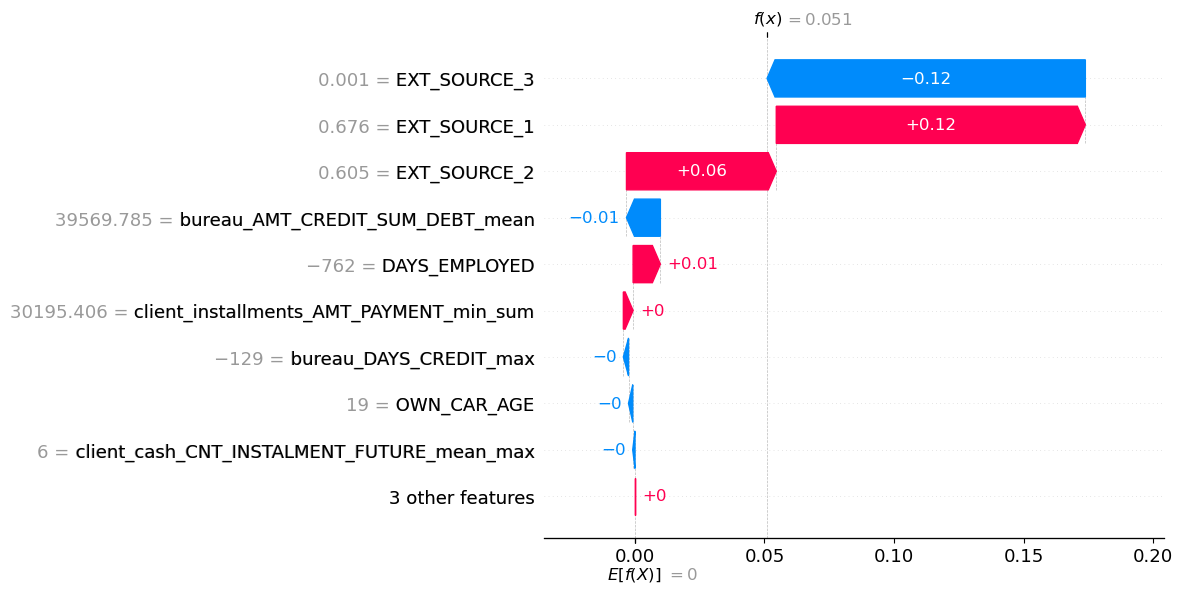

In [70]:
# Créer le graphique waterfall pour cet individu
shap.plots.waterfall(shap.Explanation(values=individual_shap_values,
                                      base_values=explainer.expected_value[0], # Assurez-vous de choisir la bonne valeur de base
                                      data=X_test_s.iloc[index],         # Données de l'individu à l'index 0
                                      feature_names=X_test_s.columns.tolist())) # Noms des caractéristiques


In [76]:
def generate_shap_waterfall(specific_id, shap_values, test_dataset, explainer, X_r):
    """
    Génère un graphique waterfall SHAP pour un individu spécifié par son ID.

    Parameters:
    - specific_id : int
        L'ID de l'individu pour lequel générer le graphique.
    - shap_values : list of numpy arrays
        Les valeurs SHAP pour les classes, typiquement [shap_values_class0, shap_values_class1].
    - test_dataset : DataFrame
        Le DataFrame contenant les identifiants des individus.
    - explainer : shap.Explainer
        L'explainer SHAP utilisé pour calculer les valeurs SHAP.
    - X_resampled : DataFrame
        Le DataFrame des données transformées (suréchantillonnées) sur lequel les valeurs SHAP ont été calculées.
    """
    # Trouver l'index de l'individu
    index = test_dataset.index.get_loc(test_dataset[test_dataset['SK_ID_CURR'] == specific_id].index[0])

    # Prédire la classe pour l'individu
    predicted_class = test_dataset.loc[test_dataset.index[index], 'target_pred']

    # Obtenir les valeurs SHAP pour la classe prédite
    individual_shap_values = shap_values[predicted_class][index]

    # Création du graphique waterfall
    shap.plots.waterfall(shap.Explanation(values=individual_shap_values,
                                          base_values=explainer.expected_value[predicted_class],
                                          data=X_r.iloc[index],
                                          feature_names=X_r.columns.tolist()))
    plt.show()


In [100]:
specific_id=389171

In [101]:
test_s[test_s['SK_ID_CURR'] == specific_id].index

Index([249923], dtype='int64')

In [102]:
index = test_s.index.get_loc(test_s[test_s['SK_ID_CURR'] == specific_id].index[0])
index

3

In [103]:
predicted_class = test_s.loc[test_s.index[index], 'target_pred']
predicted_class

0

In [104]:
individual_shap_values = shap_values[predicted_class][index]
individual_shap_values

array([-0.00408124,  0.05423871, -0.00620517,  0.01577342,  0.        ,
        0.00364576, -0.04207961,  0.        , -0.00130114,  0.03525988,
        0.06655253,  0.        ])

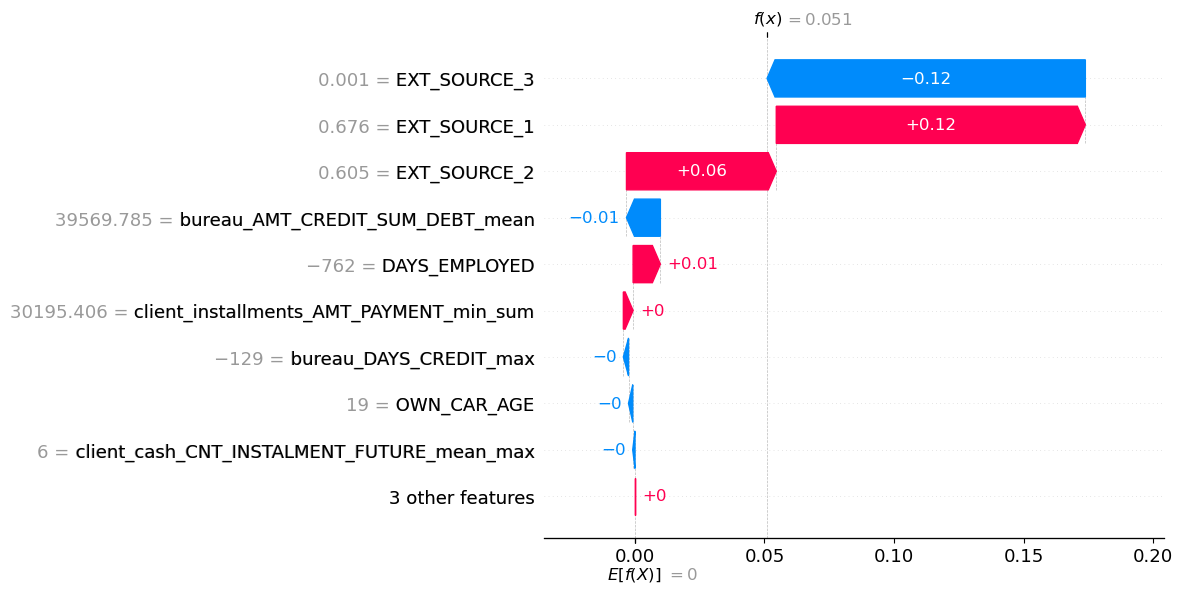

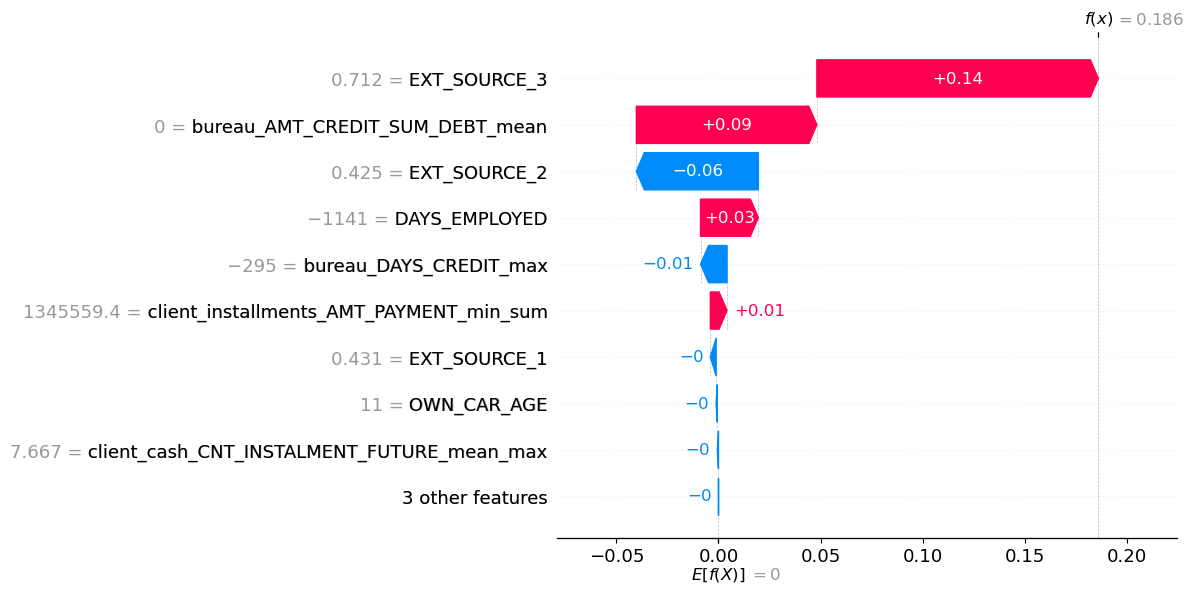

In [77]:
# Pour un individu prédit en classe 1
generate_shap_waterfall(384575, shap_values, test_s, explainer, X_test_s)

# Pour un individu prédit en classe 0
generate_shap_waterfall(214010, shap_values, test_s, explainer, X_test_s)


In [117]:
def generate_shap_waterfall(model_pipeline, X_input, feature_names):
    # Extract the model from the pipeline
    model = model_pipeline.named_steps['model']
    preprocessor = model_pipeline.named_steps['preprocessor']
    
    # Transform the input data using the preprocessor
    X_transformed = preprocessor.transform(X_input)
    
    # Create an explainer
    explainer = shap.Explainer(model, X_transformed)
    shap_values = explainer(X_transformed)
   
    shap.initjs()
    fig, ax = plt.subplots()
    shap.plots.waterfall(shap.Explanation(values=shap_values[0].values,
                                          base_values=shap_values[0].base_values,
                                          data=X_input.iloc[0],
                                          feature_names=feature_names))
    return fig

In [118]:
test_s.iloc[0]

EXT_SOURCE_1                                   0.675878
EXT_SOURCE_2                                   0.604894
EXT_SOURCE_3                                   0.000527
DAYS_EMPLOYED                                    -762.0
DAYS_BIRTH                                        13297
client_installments_AMT_PAYMENT_min_sum       30195.406
bureau_DAYS_CREDIT_max                           -129.0
bureau_DAYS_CREDIT_ENDDATE_max                    231.0
client_cash_CNT_INSTALMENT_FUTURE_mean_max          6.0
OWN_CAR_AGE                                        19.0
bureau_AMT_CREDIT_SUM_DEBT_mean               39569.785
DAYS_ID_PUBLISH                                   -4307
TARGET                                            False
SK_ID_CURR                                       384575
target_pred                                           0
proba                                          0.487253
Name: 245895, dtype: object

In [119]:
test_s.iloc[0].index

Index(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_EMPLOYED',
       'DAYS_BIRTH', 'client_installments_AMT_PAYMENT_min_sum',
       'bureau_DAYS_CREDIT_max', 'bureau_DAYS_CREDIT_ENDDATE_max',
       'client_cash_CNT_INSTALMENT_FUTURE_mean_max', 'OWN_CAR_AGE',
       'bureau_AMT_CREDIT_SUM_DEBT_mean', 'DAYS_ID_PUBLISH', 'TARGET',
       'SK_ID_CURR', 'target_pred', 'proba'],
      dtype='object')

In [120]:
test_s.iloc[0].values

array([0.67587805, 0.60489434, 0.00052726525, -762.0, 13297, 30195.406,
       -129.0, 231.0, 6.0, 19.0, 39569.785, -4307, False, 384575, 0,
       0.487253000282962], dtype=object)

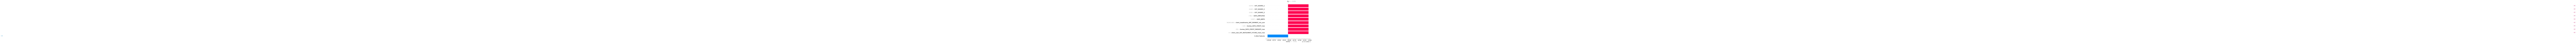

In [123]:
generate_shap_waterfall(best_model_lgbm_3, test_s.iloc[:1], test_s.columns)
plt.show()               

# 9 - Sérialisation du modèle

Sérialisation = le fait de convertir un objet qui est stocké de façon numérique sur notre mémoire ram. et le stocker sous forme de binaire sur notre ordiinateur. la pipeline était dans notre mémoire vive. On veut la stocker sous forme de fichier pour pouvoir la réutiliser plus tard.

On peut sérialser en pickle ou en joblib. Avec Scikit Learn, on recommande joblib

In [78]:
import joblib

joblib.dump(best_model_lgbm_3, 'credit_scoring_xs.joblib')

['credit_scoring_xs.joblib']

# 10 - Déploiement du modèle en local avec Streamlit

Il faut créer un nouveau fichier Python (par exemple app.py) pour le déploiement avec Streamlit. Je l'ai créé et enregistrer sous ce nom : 'app.py'

J'ai systématiquement des erreurs. Ci-dessous toutes les vérif que j'ai faites et c'est ok.

In [ ]:
import mlflow
from mlflow.tracking import MlflowClient

# Votre run_id
run_id = "43be00c851724756aa0f6408ec39c83d"

# Créer un client MLflow
client = MlflowClient()

# Vérifier si le run_id existe
try:
    run = client.get_run(run_id)
    print(f"Run {run_id} found with status {run.info.status}")
except mlflow.exceptions.MlflowException as e:
    print(f"Run {run_id} not found. Error: {e}")


In [ ]:
# Load the model back for predictions as a generic Python Function model
loaded_model = mlflow.pyfunc.load_model(model_info.model_uri)
# predict


In [ ]:
loaded_model

Ensuite je vais dans Anaconda, je me place dans input avec cd. Puis je lance la commande : streamlit run app.py
Mais j'ai un message d'erreur : NameError: name 'b89a2f5c93d24c78a92835e16a4e2b1f' is not defined

In [ ]:
import mlflow
from mlflow.tracking import MlflowClient
import os

# Assurez-vous que l'URI du serveur de suivi est correct (si vous utilisez un serveur distant)
# mlflow.set_tracking_uri("http://<your-tracking-server>:5000")

# Vérifiez l'emplacement du magasin de suivi local
print(f"MLflow Tracking URI: {mlflow.get_tracking_uri()}")

# Votre run_id
run_id = "b89a2f5c93d24c78a92835e16a4e2b1f"

# Créer un client MLflow
client = MlflowClient()

# Vérifier si le run_id existe
try:
    run = client.get_run(run_id)
    print(f"Run {run_id} found with status {run.info.status}")
except mlflow.exceptions.MlflowException as e:
    print(f"Run {run_id} not found. Error: {e}")

# Récupérer l'URI du modèle
artifact_path = "lgbm_classifier_model"
model_uri = f"runs:/{run_id}/{artifact_path}"
print(f"Model URI: {model_uri}")

# Charger le modèle depuis MLflow pour vérifier
try:
    model = mlflow.lightgbm.load_model(model_uri)
    print("Le modèle a été chargé avec succès")
except mlflow.exceptions.MlflowException as e:
    print(f"Erreur lors du chargement du modèle: {e}")


In [ ]:
import streamlit as st
import mlflow
import mlflow.lightgbm
from mlflow.tracking import MlflowClient
import pandas as pd

# Assurez-vous que l'URI du serveur de suivi est correct (si vous utilisez un serveur distant)
# mlflow.set_tracking_uri("http://<your-tracking-server>:5000")

# run_id 
run_id = "b89a2f5c93d24c78a92835e16a4e2b1f"

# Chemin relatif vers le modèle dans les artefacts de l'exécution
artifact_path = "lgbm_classifier_model"

# Créer un client MLflow
client = MlflowClient()

# Récupérer l'URI du modèle
model_uri = f"runs:/{run_id}/{artifact_path}"
print(f"Model URI: {model_uri}")

# Charger le modèle depuis MLflow
try:
    model = mlflow.lightgbm.load_model(model_uri)
    print("Le modèle a été chargé avec succès")
except mlflow.exceptions.MlflowException as e:
    st.write(f"Erreur lors du chargement du modèle: {e}")
    st.stop()

# Interface utilisateur Streamlit
st.title("Credit Scoring Prediction")

# Création du formulaire pour les entrées utilisateur
st.header("Enter the details:")
SK_ID_CURR = st.number_input("SK_ID_CURR", min_value=0, step=1)
EXT_SOURCE_1 = st.number_input("EXT_SOURCE_1", min_value=0.0, step=0.1)
EXT_SOURCE_2  = st.number_input("EXT_SOURCE_2", min_value=0.0, step=0.1)
EXT_SOURCE_3   = st.number_input("EXT_SOURCE_3", min_value=0.0, step=0.1)
DAYS_EMPLOYED    = st.number_input("DAYS_EMPLOYED", min_value=0.0, step=0.1)
DAYS_BIRTH    = st.number_input("DAYS_BIRTH", min_value=0.0, step=0.1)
client_installments_AMT_PAYMENT_min_sum    = st.number_input("client_installments_AMT_PAYMENT_min_sum", min_value=0.0, step=0.1)
bureau_DAYS_CREDIT_max    = st.number_input("bureau_DAYS_CREDIT_max", min_value=0.0, step=0.1)
bureau_DAYS_CREDIT_ENDDATE_max    = st.number_input("bureau_DAYS_CREDIT_ENDDATE_max", min_value=0.0, step=0.1)
client_cash_CNT_INSTALMENT_FUTURE_mean_max    = st.number_input("client_cash_CNT_INSTALMENT_FUTURE_mean_max", min_value=0.0, step=0.1)
OWN_CAR_AGE    = st.number_input("OWN_CAR_AGE", min_value=0.0, step=0.1)
bureau_AMT_CREDIT_SUM_DEBT_mean    = st.number_input("bureau_AMT_CREDIT_SUM_DEBT_mean", min_value=0.0, step=0.1)
DAYS_ID_PUBLISH     = st.number_input("DAYS_ID_PUBLISH", min_value=0.0, step=0.1)

# Bouton de prédiction
if st.button("Predict"):
    # Créer un DataFrame pour les entrées
    input_data = pd.DataFrame({
        'SK_ID_CURR': [SK_ID_CURR],
        'EXT_SOURCE_1': [EXT_SOURCE_1],
        'EXT_SOURCE_2': [EXT_SOURCE_2],
        'EXT_SOURCE_3': [EXT_SOURCE_3],
        'DAYS_EMPLOYED': [DAYS_EMPLOYED],
        'DAYS_BIRTH': [DAYS_BIRTH],
        'client_installments_AMT_PAYMENT_min_sum': [client_installments_AMT_PAYMENT_min_sum],
        'bureau_DAYS_CREDIT_max': [bureau_DAYS_CREDIT_max],
        'bureau_DAYS_CREDIT_ENDDATE_max': [bureau_DAYS_CREDIT_ENDDATE_max],
        'client_cash_CNT_INSTALMENT_FUTURE_mean_max': [client_cash_CNT_INSTALMENT_FUTURE_mean_max],
        'OWN_CAR_AGE': [OWN_CAR_AGE],
        'bureau_AMT_CREDIT_SUM_DEBT_mean': [bureau_AMT_CREDIT_SUM_DEBT_mean],
        'DAYS_ID_PUBLISH': [DAYS_ID_PUBLISH]
    })

    # Effectuer la prédiction
    prediction = model.predict(input_data)
    probability = model.predict_proba(input_data)[:, 1]

    # Afficher les résultats
    st.subheader("Prediction")
    st.write(f"Predicted Class: {prediction[0]}")
    st.write(f"Probability of Default: {probability[0]:.2f}")
